<a href="https://colab.research.google.com/github/XiaoLiang28/Xiao/blob/main/Presentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **About Dataset**

Since 2009, at least 177 of America’s schools experienced a shooting. These tragedies are as diverse as our nation, but the depth of trauma is hard to convey. There is no standard definition for what qualifies as a school shooting in the US. Nor is there a universally accepted database. So CNN built our own. We examined 10 years of shootings on K-12 campuses and found two sobering truths: School shootings are increasing, and no type of community is spared.
![image.png](attachment:089d2c85-c2aa-4058-8e57-99b6c2b6e070.png)!

<ul>
<li><strong>LONCOD:</strong> Longitude code</li>
<li><strong>LATCOD:</strong> Latitude code</li>
<li><strong>CDCODE:</strong> Code for the Center for Disease Control and Prevention (CDC)</li>
<li><strong>year:</strong> Year of the incident</li>
<li><strong>school:</strong> Name of the school</li>
<li><strong>city:</strong> City where the incident occurred</li>
<li><strong>state:</strong> State where the incident occurred</li>
<li><strong>address:</strong> Address where the incident occurred</li>
<li><strong>urbanrural:</strong> Whether the incident occurred in an urban or rural area</li>
<li><strong>race:</strong> Race of the perpetrator or victims (if applicable)</li>
<li><strong>killed:</strong> Number of people killed in the incident</li>
<li><strong>injured:</strong> Number of people injured in the incident</li>
<li><strong>victims:</strong> Total number of victims in the incident (including those killed and injured)</li>
<li><strong>date:</strong> Date of the incident</li>
<li><strong>type:</strong> Type of incident (e.g., shooting, stabbing, etc.)</li>
<li><strong>NCESSCH:</strong> National Center for Education Statistics (NCES) School ID</li>
<li><strong>time:</strong> Time of the incident</li>
</ul>

# **EDA**


In [59]:
import pandas as pd
import numpy as np
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import scipy.stats as stats
from scipy.stats import f_oneway
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent='my_application')
from folium.plugins import TimestampedGeoJson
import plotly.express as px
from datetime import datetime

from folium.plugins import MarkerCluster

In [60]:
df=pd.read_csv("https://github.com/XiaoLiang28/Xiao/raw/main/dataset%20for%20presentation.csv")

## Handle Null Values Using GeoPy Lib


In [61]:
def nullvalues(df):
    null_counts = df.isnull().sum()
    null_cols = null_counts[null_counts > 0].index.tolist()
    if null_cols:
        print(f'Total null values: {null_counts.sum()}')
        print(f'Columns with null values: {", ".join(null_cols)}')
        for col in null_cols:
            print(f'Number of null values in {col}: {null_counts[col]}')
    else:
        print('No null values found.')
nullvalues(df)

Total null values: 38
Columns with null values: LONCOD, LATCOD, CDCODE, urbanrural, race, NCESSCH, time
Number of null values in LONCOD: 3
Number of null values in LATCOD: 3
Number of null values in CDCODE: 11
Number of null values in urbanrural: 3
Number of null values in race: 7
Number of null values in NCESSCH: 5
Number of null values in time: 6


In [62]:
lat = df['LATCOD'].isnull()
lon = df['LONCOD'].isnull()
df_latlon = df[lat & lon]
df_latlon

,LONCOD,LATCOD,CDCODE,year,school,city,state,address,urbanrural,race,killed,injured,victims,date,type,NCESSCH,time
80,NaN,NaN,NaN,2015,Duval County school bus,Jacksonville,Florida,118th Street and Blanding Boulevard,NaN,NaN,0,2,2,14-May-15,K-12,NaN,4:20PM
111,NaN,NaN,NaN,2016,Smalls Athletic Field,York,Pennsylvania,31 Hamilton Ave,NaN,NaN,0,2,2,9-Sep-16,High School,NaN,9:30PM
137,NaN,NaN,NaN,2017,JFK Stadium,Springfield,Missouri,1333 S Grant Ave,NaN,NaN,0,1,1,22-Jun-17,High School,NaN,6:45PM


As the above data frame shows that there are three rows containing null values for latitude and longitude. However, we can use the city's latitude and longitude to fill these null values.

In [64]:
def geocode_city(city):
    location = geolocator.geocode(city)
    if location is not None:
        return location.latitude, location.longitude
    else:
        return None, None

for index, row in df.iterrows():
    if pd.isnull(row['LATCOD']) or pd.isnull(row['LONCOD']):
        latitude, longitude = geocode_city(row['city'])
        df.at[index, 'LATCOD'] = latitude
        df.at[index, 'LONCOD'] = longitude

After apply the function, check the null values.

In [65]:
nullvalues(df)

Total null values: 32
Columns with null values: CDCODE, urbanrural, race, NCESSCH, time
Number of null values in CDCODE: 11
Number of null values in urbanrural: 3
Number of null values in race: 7
Number of null values in NCESSCH: 5
Number of null values in time: 6


## **Using a geography map to visualize the killed student with their respective location.** 


In [66]:
print("max killed", df['killed'].max())
print("min killed", df['killed'].min())

max killed 26
min killed 0


The maximum number of killed students is 26. We can categories in three different categories to use different color formats in the map.
1. <span style='color:green'> Green = 0 Killed student ( Safe) </span>
2. <span style='color:black'> Yellow= less than 5 killed </span>
3. <span style='color:red'> Red Danger: more than 5 killed </span>


In [67]:

m = folium.Map(location=[37.0902, -95.7129], zoom_start=4)
for index, row in df.iterrows():
    lat = row['LATCOD']
    lon = row['LONCOD']
    city = row['city']
    school = row['school']
    killed = row['killed']
    
    if killed == 0:
        color = 'green'
    elif killed < 5:
        color = 'yellow'
    else:
        color = 'red'
    
    radius = killed * 5
    
    popup = folium.Popup('School: {}, : City {}, Killed: {}'.format(city, school, killed), parse_html=True)
    
    folium.CircleMarker(location=[lat, lon], radius=radius, color=color, fill=True, fill_color=color, popup=popup).add_to(m)

# Display the map
m


In [69]:
latitudes = df['LATCOD'].dropna().astype(float).tolist()
longitudes = df['LONCOD'].dropna().astype(float).tolist()
killed = df['killed'].dropna().astype(int).tolist()
dates = df['date'].tolist()

# Create map centered on the US
m = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

# Add marker cluster layer
marker_cluster = MarkerCluster().add_to(m)

# Iterate over the data and add markers to the map
for lat, lon, num_killed, date in zip(latitudes, longitudes, killed, dates):
    if not pd.isna(lat) and not pd.isna(lon):
        popup_text = f"{num_killed} killed on {date}"
        folium.CircleMarker(location=[lat, lon], radius=num_killed, popup=popup_text).add_to(marker_cluster)

# Display the map
m


## Timestamp map with folium library

In [70]:
df['date'] = pd.to_datetime(df['date'], format='%d-%b-%y')


data = df[['LONCOD', 'LATCOD', 'killed', 'date']]

# Convert the date column to datetime format
data['date'] = pd.to_datetime(df['date'], format='%d-%b-%y')

# Group the data by date and location and sum the number of people killed
data = df.groupby(['date', 'LATCOD', 'LONCOD']).sum().reset_index()

# Create a function to format the data for the TimestampedGeoJson plugin
def create_geojson_features(df):
    features = []
    for _, row in df.iterrows():
        feature = {
            'type': 'Feature',
            'geometry': {
                'type': 'Point',
                'coordinates': [row['LONCOD'], row['LATCOD']]
            },
            'properties': {
                'time': row['date'].date().isoformat(),
                'icon': 'circle',
                'iconstyle': {
                    'fillColor': 'red',
                    'fillOpacity': 0.8,
                    'stroke': 'false',
                    'radius': row['killed'] * 5
                }
            }
        }
        features.append(feature)
    return features

school_map = folium.Map(location=[39.8283, -98.5795], zoom_start=4)

TimestampedGeoJson(
    {'type': 'FeatureCollection', 'features': create_geojson_features(data)},
    period='P1M',
    add_last_point=True,
    auto_play=True,
    loop=True,
    max_speed=1,
    loop_button=True,
    date_options='YYYY-MM-DD',
    time_slider_drag_update=True,
).add_to(school_map)

# Display the map
school_map


<ipython-input-70-d5bab9f4d42b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(df['date'], format='%d-%b-%y')
<ipython-input-70-d5bab9f4d42b>:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = df.groupby(['date', 'LATCOD', 'LONCOD']).sum().reset_index()


## Monthwise Killed number

In [71]:
# create a new column for the month
df['month'] = df['date'].dt.month_name()

# group the data by month and count the number of students killed
monthly_counts = df.groupby('month')['killed'].sum()

# create a list of the month names in the correct order
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# reindex the monthly_counts Series with the month_order list
monthly_counts = monthly_counts.reindex(month_order)

# print the monthly counts
print(monthly_counts)

month
January       9
February     27
March         5
April         4
May          15
June          6
July          1
August        3
September     4
October       9
November      2
December     29
Name: killed, dtype: int64


In [72]:
def count_killed_by_month(df):
    df['date'] = pd.to_datetime(df['date'], format='%d-%b-%y', errors='coerce')
    df = df.dropna(subset=['date'])
    df['month'] = df['date'].dt.month
    df['month'] = df['month'].apply(lambda x: calendar.month_abbr[x])
    df['year'] = df['date'].dt.year
    df['count'] = 1
    killed_by_month = df.groupby(['year', 'month'])['killed', 'count'].sum()
    killed_by_month = killed_by_month.reset_index()
    # add missing months
    all_months = list(calendar.month_abbr)[1:]
    all_years = range(df['year'].min(), df['year'].max()+1)
    missing_months = [(y, m) for y in all_years for m in all_months if (y, m) not in zip(killed_by_month['year'], killed_by_month['month'])]
    missing_df = pd.DataFrame(missing_months, columns=['year', 'month'])
    missing_df['killed'] = 0
    missing_df['count'] = 0
    killed_by_month = pd.concat([killed_by_month, missing_df])
    killed_by_month = killed_by_month.sort_values(['year', 'month'], ascending=[True, True])
    killed_by_month = killed_by_month[['year', 'month', 'killed', 'count']]
    # print results
    print('\033[1m' + 'Month-wise count of students killed:' + '\033[0m')
    print(killed_by_month)
    print('\n')
    print('\033[1m' + 'Number of null date values:' + '\033[0m')
    print(df['date'].isnull().sum())


In [73]:
count_killed_by_month(df)

Month-wise count of students killed:
    year month  killed  count
0   2009   Apr       0      0
2   2009   Aug       0      0
0   2009   Dec       0      2
1   2009   Feb       0      2
2   2009   Jan       1      3
..   ...   ...     ...    ...
76  2018   Mar       2      2
77  2018   May      11      4
78  2018   Nov       0      1
79  2018   Oct       1      3
80  2018   Sep       1      2

[120 rows x 4 columns]


Number of null date values:
0


<ipython-input-72-bff208dda12b>:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  killed_by_month = df.groupby(['year', 'month'])['killed', 'count'].sum()


## Statistical hypothesis test to test relationship between number of killed to victims

* Null hypothesis (H0): There is no linear correlation between the number of victims and the number of killed
* Alternative hypothesis (Ha): There is a linear correlation between the number of victims and the number of killed.

In [74]:
from scipy.stats import pearsonr

corr, p_val = pearsonr(df['victims'], df['killed'])

print('Pearson correlation coefficient:', corr)
print('p-value:', p_val)


Pearson correlation coefficient: 0.8888923921477881
p-value: 3.0218484274696066e-62


**Above values show positive linear correlation between the number of victims and the number of killed**.P values is more than 0.05. We can reject null hypothesis.

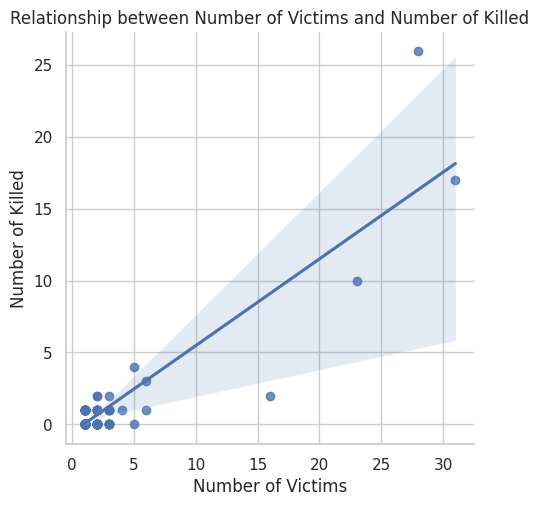

In [75]:


sns.set(style="whitegrid")

# create scatter plot with regression line
sns.lmplot(x="victims", y="killed", data=df)

# set axis labels and plot title
plt.xlabel("Number of Victims")
plt.ylabel("Number of Killed")
plt.title("Relationship between Number of Victims and Number of Killed")

# display the plot
plt.show()


## Statistical hypothesis test to test  number of killed among the different racial groups & barchart

* Null hypothesis (H0): There is no significant difference in the mean number of killed among the different racial groups. 
* Alternative hypothesis (Ha): There is a significant difference in the mean number of killed among the different racial groups.

In [76]:
df = df.dropna(subset=['race'])
df = df[df['race'] != 'Unknown']

# Create separate data frames for each race
df_black = df[df['race'] == 'BLACK']
df_white = df[df['race'] == 'WHITE']
df_hisp = df[df['race'] == 'HISP']
df_asian = df[df['race'] == 'ASIAN']

# Extract the number of killings for each race
killings_black = df_black['killed']
killings_white = df_white['killed']
killings_hisp = df_hisp['killed']
killings_asian = df_asian['killed']

# Perform ANOVA test
f_statistic, p_value = f_oneway(killings_black, killings_white, killings_hisp, killings_asian)

# Print results
print("F-statistic:", f_statistic)
print("p-value:", p_value)

F-statistic: 1.6552498674921523
p-value: 0.17861335851839902


**The F-statistic of 1.655 and the p-value of 0.179 suggest that there is no significant difference in the number of killings among the different races. The null hypothesis cannot be rejected.**

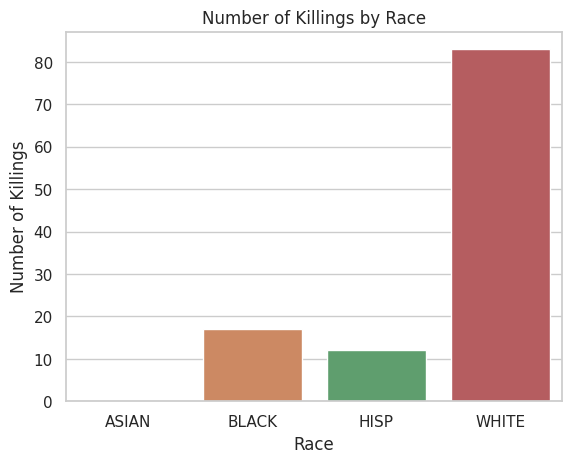

In [77]:

# Count number of killings for each race
killed_counts = df.groupby('race')['killed'].sum().reset_index()

# Plot barplot using Seaborn
sns.barplot(x='race', y='killed', data=killed_counts)
plt.title('Number of Killings by Race')
plt.xlabel('Race')
plt.ylabel('Number of Killings')
plt.show()


## Barchart of number of killed over the Year & Moonth-Year

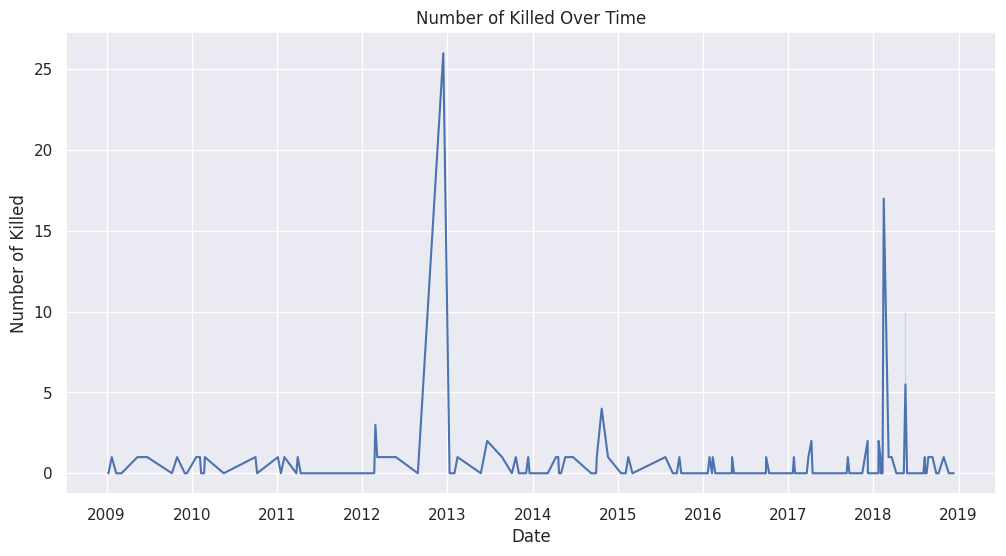

In [78]:
df['date'] = pd.to_datetime(df['date'])

# group by date and sum killed column
df_killed = df.groupby('date')['killed'].sum().reset_index()

# create plot
sns.set_style("darkgrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x="date", y="killed")
plt.title("Number of Killed Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Killed")
plt.show()

<Axes: xlabel='year', ylabel='killed'>

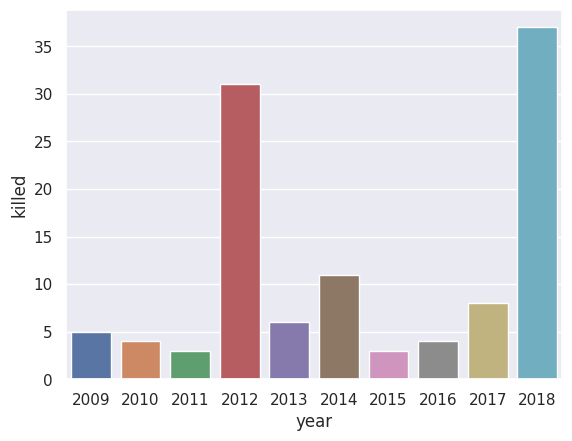

In [79]:
killed_per_year = df.groupby('year')['killed'].sum().reset_index()

sns.barplot(x='year', y='killed', data=killed_per_year)

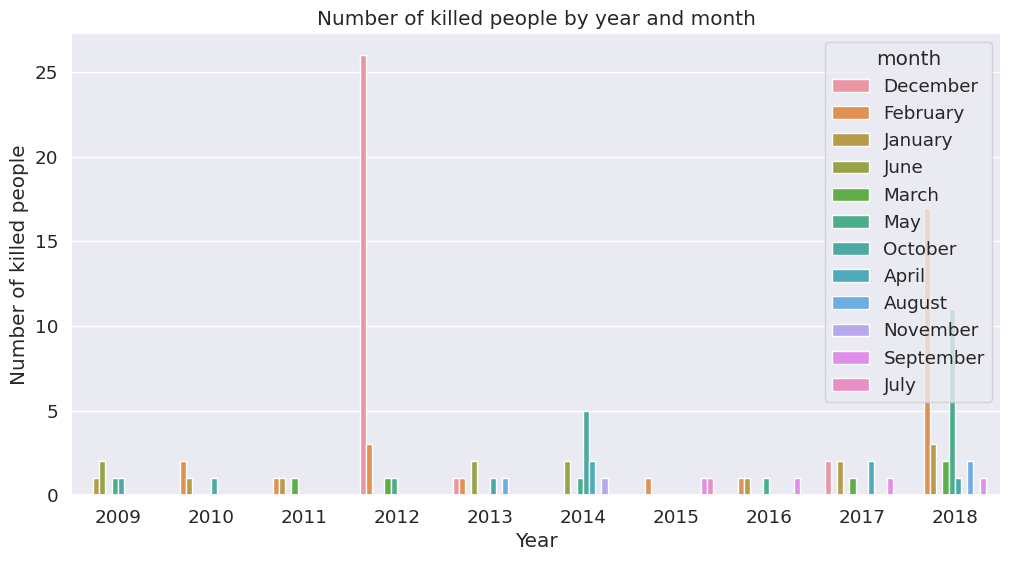

In [80]:
df['date'] = pd.to_datetime(df['date'], format='%d-%b-%y')

# Create a new column for year and month
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month_name()

# Group by year and month and count the number of killed people
killed_by_year_month = df.groupby(['year', 'month'])['killed'].sum().reset_index()

# Plot the barplot
sns.set_style("whitegrid")
sns.set_palette("Set2")
sns.set(font_scale=1.2)
plt.figure(figsize=(12, 6))
sns.barplot(x='year', y='killed', hue='month', data=killed_by_year_month)
plt.title("Number of killed people by year and month")
plt.xlabel("Year")
plt.ylabel("Number of killed people")
plt.show()

## Relationship between Number of Victims and Number of Injured

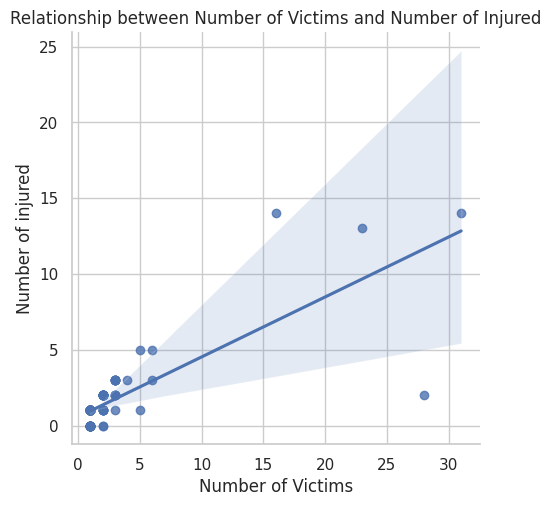

In [81]:


sns.set(style="whitegrid")

# create scatter plot with regression line
sns.lmplot(x="victims", y="injured", data=df)

# set axis labels and plot title
plt.xlabel("Number of Victims")
plt.ylabel("Number of injured")
plt.title("Relationship between Number of Victims and Number of Injured")

# display the plot
plt.show()


## Number of Killed, Injured, and Victims by Urbanrural

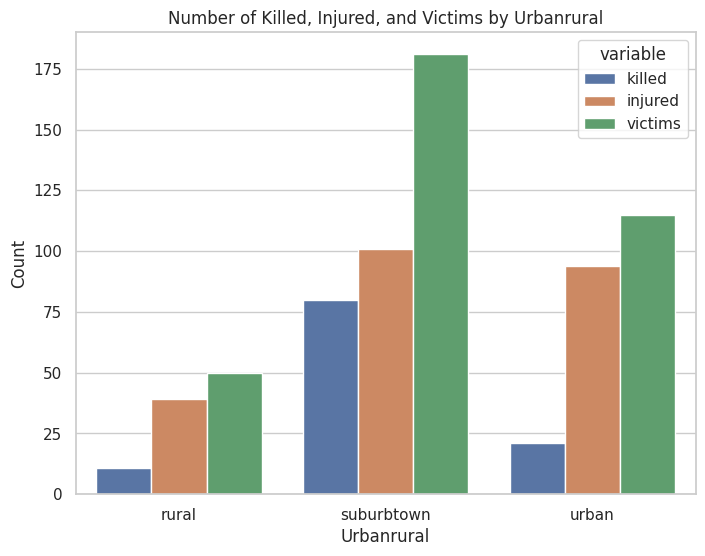

In [82]:
urbanrural_data = df.groupby('urbanrural')[['killed', 'injured', 'victims']].sum().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(x='urbanrural', y='value', hue='variable', 
            data=pd.melt(urbanrural_data, id_vars='urbanrural', value_vars=['killed', 'injured', 'victims']))
plt.title('Number of Killed, Injured, and Victims by Urbanrural')
plt.xlabel('Urbanrural')
plt.ylabel('Count')
plt.show()


## Number of Killed, Injured, and Victims by School Type

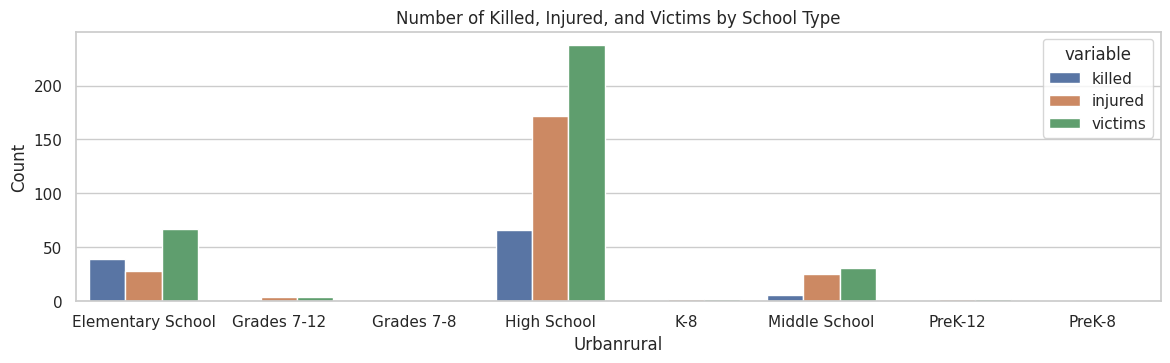

In [83]:


sns.set_style('whitegrid')

urbanrural_data = df.groupby('type')[['killed', 'injured', 'victims']].sum().reset_index()
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(14, 3.5))
sns.barplot(x='type', y='value', hue='variable', 
            data=pd.melt(urbanrural_data, id_vars='type', value_vars=['killed', 'injured', 'victims']))
plt.title('Number of Killed, Injured, and Victims by School Type')
plt.xlabel('Urbanrural')
plt.ylabel('Count')
plt.show()


## Using date column, converting date & time in morning,afternoon & evening

In [84]:
df["time"] = pd.to_datetime(df["time"], format="%I:%M%p")
df["time_of_day"] = pd.cut(df["time"].dt.hour, bins=[0, 12, 17, 23], labels=["morning", "noon", "afternoon"])

df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")

df["datetime"] = df["date"] + pd.to_timedelta(df["time"].dt.strftime('%H:%M:%S'))

## Number of incidents based on morning, afternoon and evening

<Axes: >

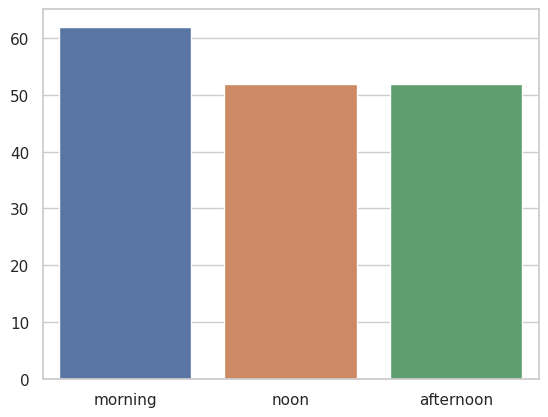

In [85]:
counts = df["time_of_day"].value_counts()

# Visualize the results using a bar plot with Seaborn
sns.barplot(x=counts.index, y=counts.values)

<Axes: xlabel='time_of_day', ylabel='count'>

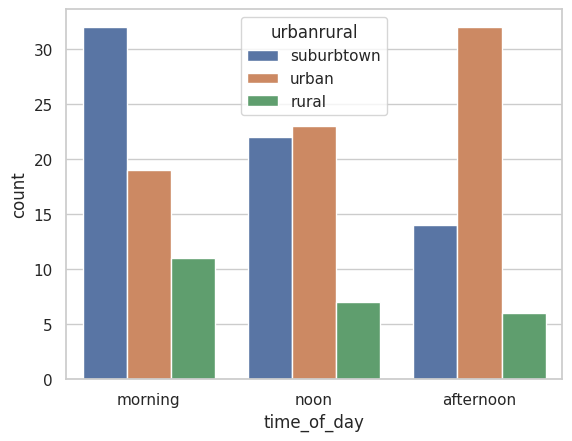

In [86]:
sns.countplot(x="time_of_day", hue="urbanrural", data=df)


## Using the month of the incident, adding new column called season (winter, summer, spring, fall) & barchart

In [87]:
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")
df["month"] = df["date"].dt.month

# Define a function to map months to seasons
def get_season(month):
    if month in [3, 4, 5]:
        return "spring"
    elif month in [6, 7, 8]:
        return "summer"
    elif month in [9, 10, 11]:
        return "fall"
    else:
        return "winter"

# Apply the function to the "month" column and create a new "season" column
df["season"] = df["month"].apply(get_season)

<Axes: xlabel='urbanrural', ylabel='count'>

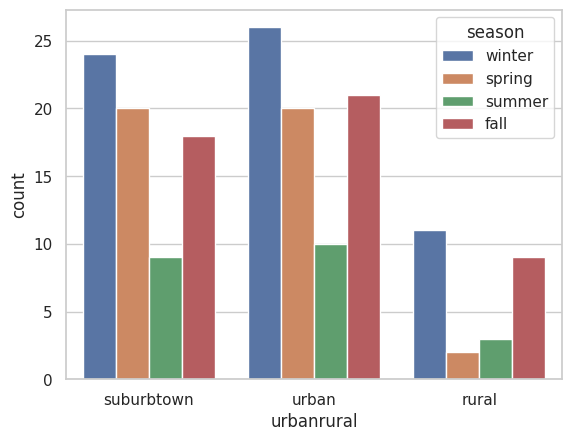

In [88]:
sns.countplot(x="urbanrural", hue="season", data=df)


## Create a new column with labels for time of day

In [89]:
df["time"] = pd.to_datetime(df["time"], format="%I:%M%p")
df["hour"] = df["time"].dt.hour

# Create a new column with labels for time of day
time_labels = ["late_night", "early_morning", "start_of_morning", "end_of_morning",
               "starting_of_noon", "end_of_noon", "starting_of_afternoon", 
               "end_of_afternoon", "starting_of_evening", "end_of_evening", 
               "starting_of_night"]
time_bins = [0, 3, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]
df["specifi time"] = pd.cut(df["hour"], bins=time_bins, labels=time_labels, include_lowest=True)

<Axes: xlabel='urbanrural', ylabel='count'>

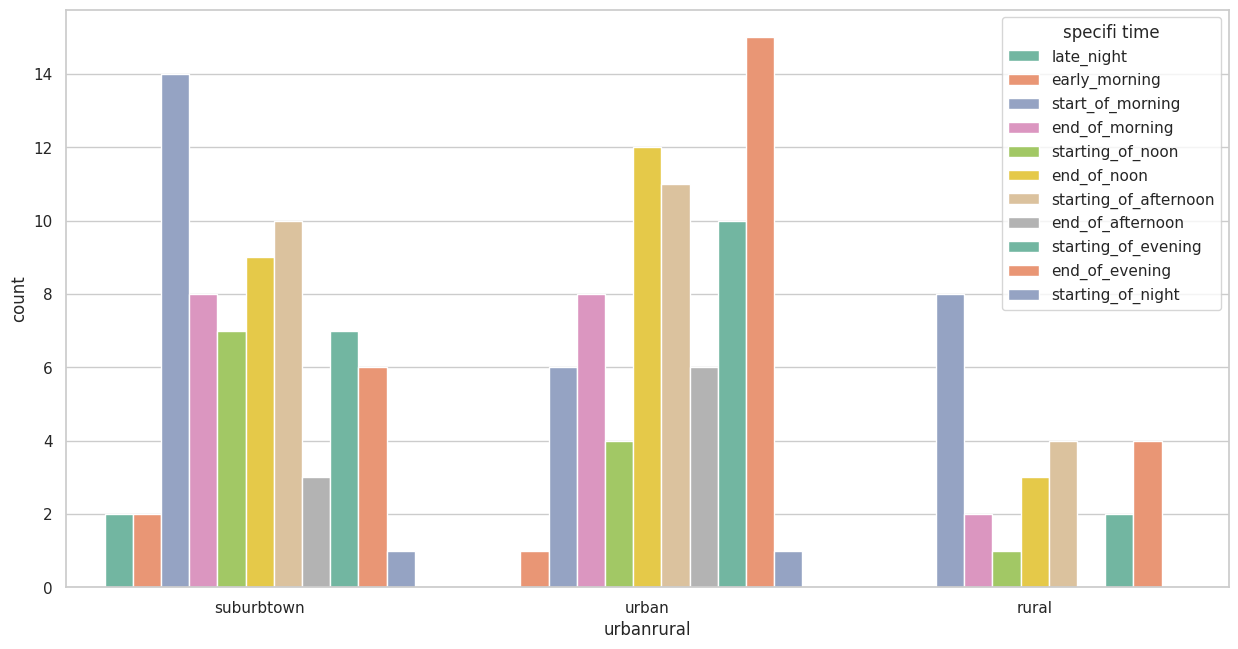

In [90]:
fig, ax = plt.subplots(figsize=(15, 7.5
    ))
sns.countplot(x="urbanrural", hue="specifi time", data=df,palette=sns.color_palette('Set2', n_colors=15))
